In [4]:
from google.colab import files
uploaded = files.upload()


Saving gig_worker_credit_risk_20000.csv to gig_worker_credit_risk_20000.csv


In [23]:
import pandas as pd
df = pd.read_csv("gig_worker_credit_risk_20000.csv")
print(df.shape)
df.head(20000)


(20000, 11)


,worker_id,platform,avg_daily_income,weekly_deliveries,active_days,rating,income_std,account_age_months,cancel_rate,monthly_income,default_risk
0,GW00001,Swiggy,1103,16,12,4.4,441,7,0.15,13236,0
1,GW00002,Zomato,507,44,10,3.5,195,26,0.15,5070,0
2,GW00003,Zomato,637,31,10,4.6,161,16,0.10,6370,0
3,GW00004,Zomato,294,57,11,3.8,112,14,0.15,3234,1
4,GW00005,Swiggy,518,41,22,5.0,260,12,0.08,11396,0
...,...,...,...,...,...,...,...,...,...,...,...
19995,GW19996,Zomato,252,60,19,3.3,338,28,0.13,4788,1
19996,GW19997,Swiggy,1179,66,27,3.9,112,9,0.23,31833,1
19997,GW19998,Swiggy,1097,24,22,4.7,300,34,0.15,24134,0
19998,GW19999,Swiggy,698,67,20,4.0,230,27,0.15,13960,0


In [10]:
X = df.drop(columns=["default_risk", "worker_id"])
y = df["default_risk"]


In [11]:
X = pd.get_dummies(X, columns=["platform"], drop_first=True)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(16000, 9) (4000, 9)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)


(16000, 9)
(4000, 9)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score



In [16]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}


In [17]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })


In [18]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="ROC-AUC", ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
1,Random Forest,0.99975,1.000000,0.999501,0.999751,1.00000
2,Gradient Boosting,1.00000,1.000000,1.000000,1.000000,1.00000
0,Logistic Regression,0.84350,0.846657,0.839900,0.843265,0.92969


In [19]:
!pip install xgboost


In [20]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

results.append({
    "Model": "XGBoost",
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1 Score": f1_score(y_test, y_pred_xgb),
    "ROC-AUC": roc_auc_score(y_test, y_prob_xgb)
})


In [21]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="ROC-AUC", ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
1,Random Forest,0.99975,1.000000,0.999501,0.999751,1.00000
2,Gradient Boosting,1.00000,1.000000,1.000000,1.000000,1.00000
3,XGBoost,1.00000,1.000000,1.000000,1.000000,1.00000
0,Logistic Regression,0.84350,0.846657,0.839900,0.843265,0.92969


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_xgb)


array([[1995,    0],
       [   0, 2005]])

In [24]:
# Predict probability of default
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]


In [25]:
credit_scores = 900 - (y_prob * 600)
credit_scores = credit_scores.round().astype(int)


In [26]:
results_df = X_test.copy()

results_df["Probability_of_Default"] = y_prob
results_df["Credit_Score"] = credit_scores
results_df["Actual_Risk"] = y_test.values
results_df["Predicted_Risk"] = (y_prob >= 0.5).astype(int)

results_df.head()


,avg_daily_income,weekly_deliveries,active_days,rating,income_std,account_age_months,cancel_rate,monthly_income,platform_Zomato,Probability_of_Default,Credit_Score,Actual_Risk,Predicted_Risk
19803,535,24,8,4.8,423,16,0.17,4280,True,0.999402,300,1,1
15742,961,17,10,4.7,204,3,0.09,9610,True,0.000004,900,0,0
5256,466,28,24,4.0,176,8,0.08,11184,False,0.002288,899,0,0
13941,655,44,14,3.5,367,3,0.23,9170,False,0.999995,300,1,1
14648,766,53,24,3.5,166,11,0.08,18384,True,0.000475,900,0,0


In [27]:
def risk_segment(score):
    if score >= 750:
        return "Low Risk"
    elif score >= 600:
        return "Medium Risk"
    else:
        return "High Risk"

results_df["Risk_Segment"] = results_df["Credit_Score"].apply(risk_segment)


In [29]:
results_df.head(30)

,avg_daily_income,weekly_deliveries,active_days,rating,income_std,account_age_months,cancel_rate,monthly_income,platform_Zomato,Probability_of_Default,Credit_Score,Actual_Risk,Predicted_Risk,Risk_Segment
19803,535,24,8,4.8,423,16,0.17,4280,True,0.999402,300,1,1,High Risk
15742,961,17,10,4.7,204,3,0.09,9610,True,0.000004,900,0,0,Low Risk
5256,466,28,24,4.0,176,8,0.08,11184,False,0.002288,899,0,0,Low Risk
13941,655,44,14,3.5,367,3,0.23,9170,False,0.999995,300,1,1,High Risk
14648,766,53,24,3.5,166,11,0.08,18384,True,0.000475,900,0,0,Low Risk
3535,1163,33,24,4.0,422,31,0.14,27912,False,0.000805,900,0,0,Low Risk
7902,291,24,26,3.6,154,33,0.21,7566,False,0.999993,300,1,1,High Risk
4839,1105,52,18,3.5,52,28,0.03,19890,False,0.000461,900,0,0,Low Risk
11388,701,16,23,3.5,143,6,0.16,16123,True,0.999489,300,1,1,High Risk
2944,523,48,25,3.2,308,18,0.18,13075,True,0.999995,300,1,1,High Risk


In [30]:
!pip install shap


In [31]:
import shap
import numpy as np


In [32]:
explainer = shap.Explainer(xgb_model, X_train_scaled)
shap_values = explainer(X_test_scaled)


 97%|=================== | 3883/4000 [00:52<00:01]       

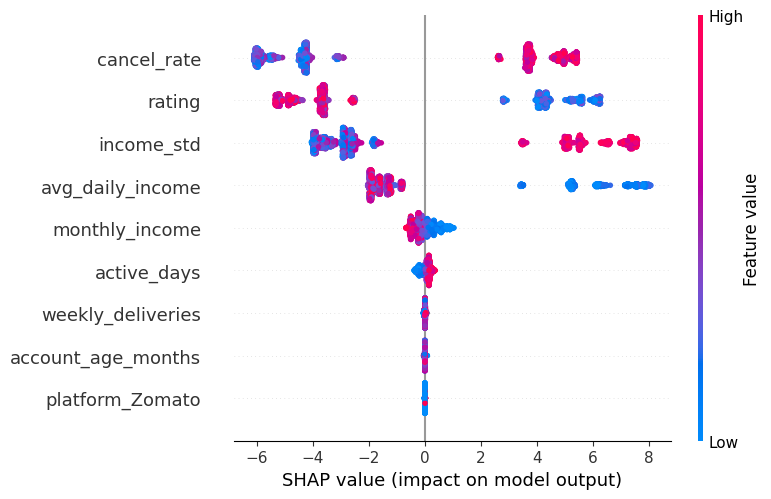

In [33]:
shap.summary_plot(shap_values, X_test)


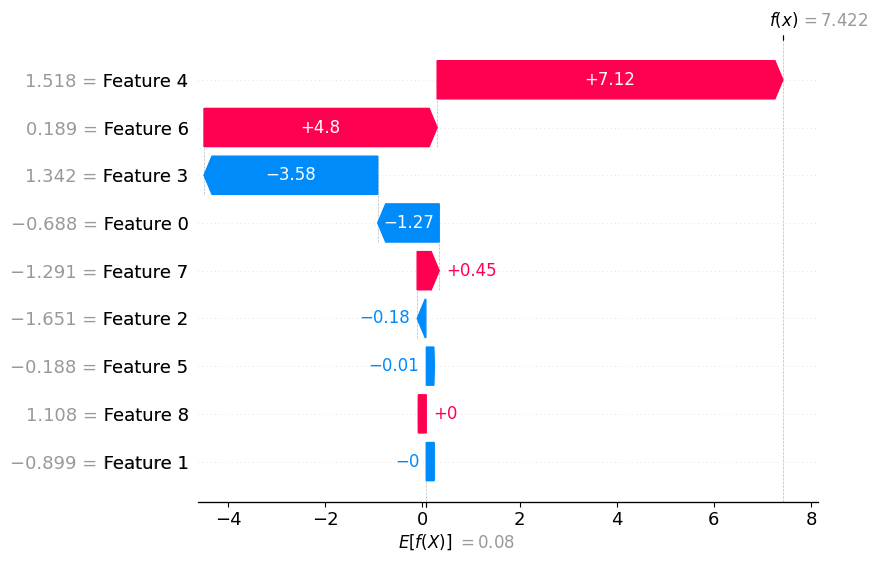

In [34]:
# Explain first test sample
shap.plots.waterfall(shap_values[0])


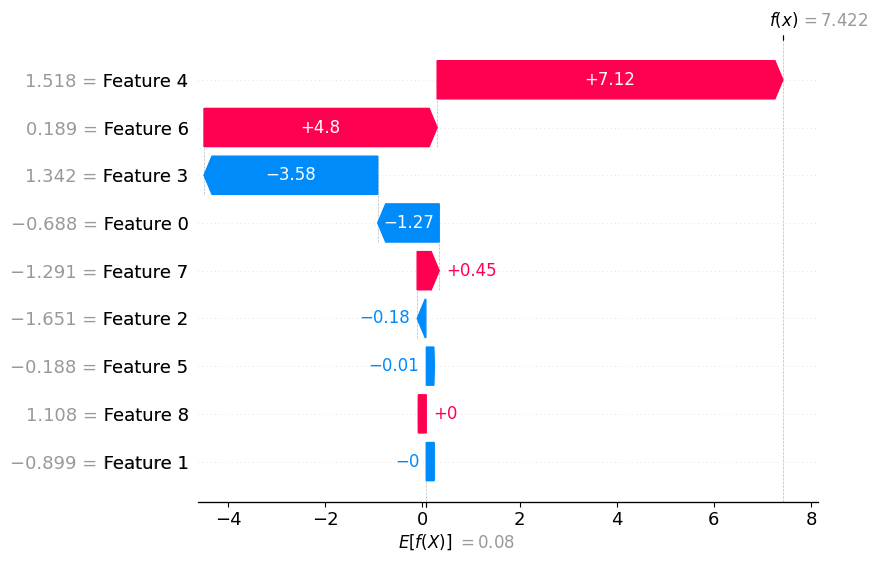

In [35]:
# High-risk sample
idx = np.where(y_test.values == 1)[0][0]
shap.plots.waterfall(shap_values[idx])


In [36]:
import joblib

joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [37]:
!ls


gig_worker_credit_risk_20000.csv  sample_data  scaler.pkl  xgb_model.pkl


In [38]:
from google.colab import files

files.download("xgb_model.pkl")
files.download("scaler.pkl")
files.download("gig_worker_credit_risk_20000.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>